**Contexte**

*Le projet consiste à mettre en place un algorithme qui permettra d’identifier automatiquement des billets contrefaits à partir leurs dimensions et des éléments qui les composent. Nous avons à notre disposition un jeu de données contenant les mésures géométriques de 1500 billets dont 1 000 sont vrais et 500 sont faux et une variable précisant la nature du billet*.

**Phase 1 : Analyse exploratoire des données**
- Description du dataset
- Traitement des valeurs manquantes en utilisant la régression linéaire

**Phase 2 : Analyse univariée**

**Phase 3 K-Means clustering**
- Methode du coude
- Silhouette score
- Plan factoriel
- Analyse des centroïdes
- Modèle d'évaluation

**Phase 4 Régression logistique**
- Mise en oeuvre
- Tests prédictifs
- Modèle d'évaluation

**Phase 5 : Validation croisée**
- Pipeline

**Phase 6 : Mise en oeuvre de la fonction de test**
- Préparation des données
- Application de la fonction de test

# Analyse exploratoire des données
---------------

**Imports modules**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pandas.plotting import parallel_coordinates

import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as st
from scipy.stats import shapiro
from scipy import stats
from scipy.stats import t
from scipy.cluster.hierarchy import dendrogram

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, linear_model, tree, naive_bayes,neighbors, ensemble, neural_network
#from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import researchpy

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Fonctions 
def shapiro_test(x):
    '''
    The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

    Parameters :
        x (array_like) : array of sample data

    Returns :
        statistic (float) : the test statistic
        p-value (float) : the p-value for the hypothesis test
    '''
    from scipy.stats import shapiro
    x1, pval1 = shapiro(x)

    print("="*100,"\n")
    print("Shapiro-Wilk test","\n")
    if pval1 < 0.05:
        print("pval1 < 0.05 ==> l'hypothèse nulle est rejetée (les résidus ne suivent pas une loi normale).)")
    else:
        print("pval1 > 0.05 ==> Nous ne pouvons pas rejeter l'hypothèse nulle H0 (les résidus suivent une loi normale.)")
    print()
    print("="*100,"\n")
    
def display_scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    Parameters: 
        pca : the result of instantian of PCA in scikit learn
    '''
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Composantes principales")
    plt.ylabel("Variance expliquée (%)")
    plt.title("Variance expliquée par composante principale")
    plt.show(block=False)
    
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''
    Display correlation circles, one for each factorial plane
    
    Parameters :
        pcs : model_pca.components
        n_comp (float) : the number of components
        pca : the result of instantiate of PCA in scikit learn
        axis_rank (float) : the rank of the axis to visualize
        labels : labels of our variables    
    '''
    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialize the matplotlib figure
            #fig, ax = plt.subplots(figsize=(8,8))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Correlation Circle (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''
    Display a scatter plot on a factorial plane, one for each factorial plane

    Parameters :
        X_projected : model_pca.transform(X_scaled)
        n_comp (float) : the number of components
        pca : the result of instantiate of PCA in scikit learn
        axis_rank : the rank of the axis to visualize
        labels : labels of our variables
    '''
    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialize the matplotlib figure      
            #fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='brown', ls='--')
            plt.plot([0, 0], [-100, 100], color='brown', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            #plt.show(block=False)
            plt.title("Projection de points (on PC{} and PC{})".format(d1+1, d2+1))

            
            
def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)  

## Dataset description

In [3]:
initial_data = pd.read_csv("billets.csv", sep=";")

In [4]:
initial_data.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
print ("Taille du dataset initial_data: ",initial_data.shape)

Taille du dataset initial_data:  (1500, 7)


In [6]:
# Noms des colonnes
initial_data.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [7]:
# Résumé du dataset
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [8]:
initial_data["is_genuine"].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [9]:
initial_data.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

**Observations** :

Nous disposons d'un jeu de données contenant les mesures géométriques de 1 500 billets de banque :

→ 1 000 sont vrais et 500 sont faux. Une variable est booléenne : elle nous donne la nature du billet de banque (Vrai ou Faux).

Danger : 37 valeurs sont manquantes dans la colonne "margin_low".

→ Nous pouvons prédire les valeurs manquantes sur la variable "margin_low" en utilisant la régression linéaire (statsmodel)

In [10]:
# Propriétés statistiques du dataset
initial_data.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.01,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


In [11]:
# Affichage de toutes les lignes ayant des valeurs manquantes dans la colonne margin_low
initial_data.loc[initial_data["margin_low"].isna(),:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


## Traitement des valeurs manquantes par régression linéaire 
---

### Régression linéaire

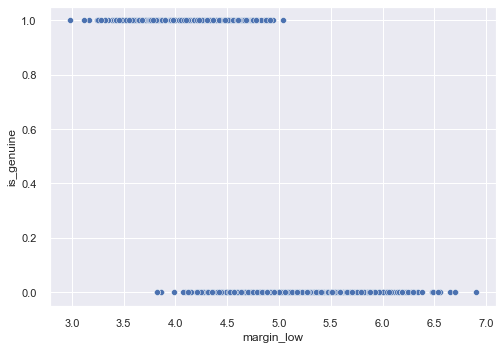

In [12]:
# Représentation graphique
sns.set()
ax = sns.scatterplot(x="margin_low", y="is_genuine", data=initial_data)

**Observations :**
Au-delà d'une marge basse de 5, on constate que les billets sont pour la plupart faux.

Nous décidons de supprimer la variable "is_genuine" pour éviter une influence de cette variable sur nos résultats.

In [13]:
# Préparation des données
df = initial_data[['diagonal', 'height_left', 'height_right', 'margin_low',
           'margin_up', 'length']]

In [14]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', 
                    data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          2.60e-202
Time:                        07:27:02   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

**Observations :**

Nous voyons ici que tous les paramètres sont significatifs et ont une valeur p inférieure à 5%, le niveau de test attendu.

R2 est le coefficient de détermination qui nous indique le pourcentage de variation de la variable indépendante qui peut être expliqué par la variable indépendante. Ici, 47,7 % de la variation de Y peut être expliquée par X. La valeur maximale possible de R2 est 1, ce qui signifie que plus la valeur de R2 est grande, meilleure est la régression.

#https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/

### Analyse des résultats

In [15]:
#Cours openclassroom Réalisez des modélisations de données performantes 
#https://openclassrooms.com/fr/courses/4525326-realisez-des-modelisations-de-donnees-performantes/5754128-decouvrez-le-jeu-de-donnees-des-maladies-cardio-vasculaires

In [16]:
# Nous effectuerons les tests à un niveau 𝛼 = 5%
alpha = 0.05

# Nombre d'individus
n = df['margin_low'].count()

# Nombre de variables
p = 6

analysis = pd.DataFrame({'obs':np.arange(1, n+1)})

**Calcul des leviers (atypicité des variables explicatives) :**

Nous considérons que le seuil des leviers est de : 2*p/n

In [17]:
analysis['levers'] = reg_multi.get_influence().hat_matrix_diag
threshold_levers = 2*p/n

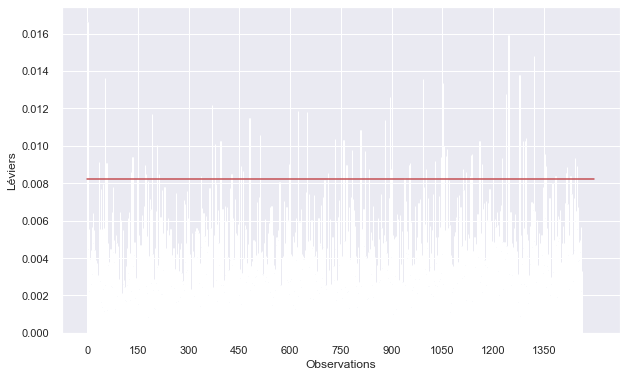

In [18]:
plt.figure(figsize=(10,6))
plt.bar(analysis['obs'], analysis['levers'])
plt.xticks(np.arange(0, 1500, step=150))
plt.xlabel('Observations')
plt.ylabel('Léviers')
plt.plot([0, 1500], [threshold_levers, threshold_levers], color='r')
plt.show()

In [19]:
# Sélection des points pour lesquels le levier est supérieur au seuil.
lev_obs = analysis.loc[analysis['levers'] > threshold_levers, :]
print(lev_obs.head(),"\n")
print(len(lev_obs),"observations sont supérieurs au seuil")

    obs    levers
0     1  0.016606
2     3  0.008298
34   35  0.009156
52   53  0.013635
56   57  0.009087 

75 observations sont supérieurs au seuil


**Calcul des résidus studentisés (atypicité de la variable à expliquer) :**

In [20]:
analysis['rstudent'] = reg_multi.get_influence().resid_studentized_internal
rstudent_threshold = t.ppf(1-alpha/2,n-p-1)

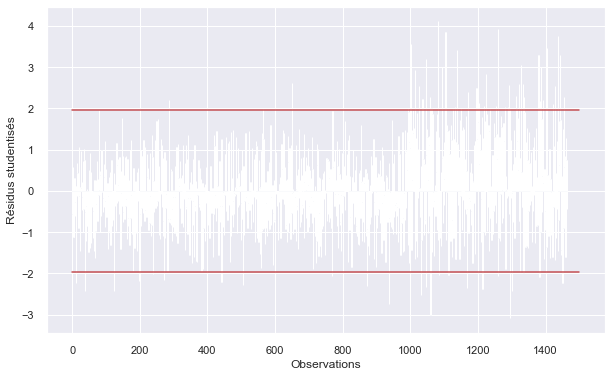

In [21]:
plt.figure(figsize=(10,6))
plt.bar(analysis["obs"], analysis["rstudent"])
plt.xticks(np.arange(0, 1500, step=200))
plt.xlabel("Observations")
plt.ylabel("Résidus studentisés")
plt.plot([0, 1500], [rstudent_threshold, rstudent_threshold], color='r')
plt.plot([0, 1500], [-rstudent_threshold, -rstudent_threshold], color='r')
plt.show()

In [22]:
rstu_obs = analysis.loc[(analysis['rstudent'] > rstudent_threshold) & (analysis['rstudent'] > -rstudent_threshold)]
print(rstu_obs.head(),"\n")
print(len(rstu_obs),"observations sont supérieures aux seuils")

     obs    levers  rstudent
285  286  0.007106  2.198945
564  565  0.004796  1.979045
649  650  0.011824  2.623086
993  994  0.013583  1.996766
998  999  0.005801  2.892652 

53 observations sont supérieures aux seuils


**Calcul de la distance de Cook**

In [23]:
influence = reg_multi.get_influence().summary_frame()

In [24]:
analysis['dcooks'] = influence['cooks_d']
dcook_threshold = 3/(n-p)

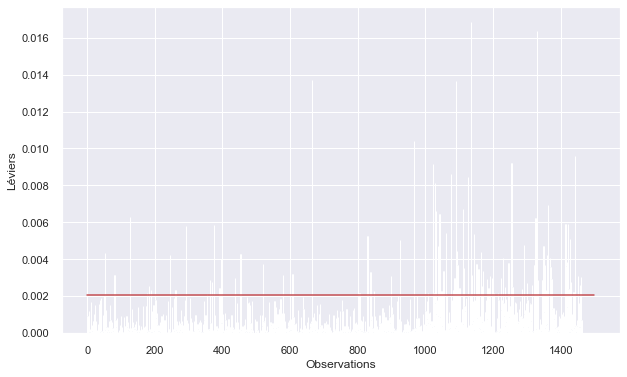

In [25]:
# Détection des observations influentes
plt.figure(figsize=(10,6))
plt.bar(analysis['obs'], analysis['dcooks'])
plt.xticks(np.arange(0, 1500, step=200))
plt.xlabel('Observations')
plt.ylabel('Léviers')
plt.plot([0, 1500], [dcook_threshold, dcook_threshold], color='r')
plt.show()

In [26]:
dcooks_obs = analysis.loc[(analysis['dcooks'] > dcook_threshold)]
print(dcooks_obs.head(),"\n")
print(len(dcooks_obs),"observations sont supérieurs aux seuils")

     obs    levers  rstudent    dcooks
52    53  0.013635 -1.372229  0.004338
80    81  0.003806  0.022997  0.003151
125  126  0.001589  0.172284  0.006308
176  177  0.002004 -0.622183  0.002176
182  183  0.002507  0.174186  0.002560 

118 observations sont supérieurs aux seuils


**Test de colinéarité des variables**

In [27]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) 
 for i in np.arange(1,variables.shape[1])]

[1.0136128990686333,
 1.138260573608249,
 1.230114515556036,
 1.4044037781843624,
 1.576950145366581]

In [28]:
# Instanciation:
reg_li_col = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length + is_genuine", 
                   data = initial_data)
# Calculs:
res_li_col = reg_li_col.fit()

variables = res_li_col.model.exog


for VIF in [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]:
    if VIF <= 10:
        print("VIF > 10 : Pas de problème de colinéarité")

VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité


**Observations :**
Tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

**Test d'homoscédasticité :**

In [29]:
# Tester la constance de la variance des résidus
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval,"\n")

if pval < 5/100:
    print("pvalue < 5% ,  H0 est rejeté : les variances sont hétéroscédastiques (non constantes).")
else : print("pvalue > 5%, H0 ne peut être rejeté : les variances sont constantes (ou homoscédastiques)")

p value test Breusch Pagan: 3.407436944157813e-32 

pvalue < 5% ,  H0 est rejeté : les variances sont hétéroscédastiques (non constantes).


**Test de normalité résiduelle :**

In [30]:
shapiro_test(reg_multi.resid)


Shapiro-Wilk test 

pval1 < 0.05 ==> l'hypothèse nulle est rejetée (les résidus ne suivent pas une loi normale).)




**Avertissement :**
* Les hypothèses du modèle linéaire ne sont pas respectées : les résidus ne sont ni gaussiens ni homoscédastiques.
* Mais étant donné la taille de notre échantillon (1500 individus), les résultats du modèle restent viables.

### Prédiction et imputation des valeurs manquantes

In [31]:
# Prédiction des valeurs manquantes
df_na = df[df["margin_low"].isnull()]
predict_na = reg_multi.predict(df_na)

In [32]:
# Imputations des valeurs manquantes
initial_data["margin_low"][initial_data["margin_low"].isnull()] = predict_na
df["margin_low"][df["margin_low"].isnull()] = predict_na

In [33]:
# Vérification après imputation
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


## Analyse en composantes principales (ACP) sur les caractéristiques

### Normalisation des données

In [34]:
# Normalisation 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Vérification
pd.DataFrame(X_scaled, columns=df.columns).describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.01,-2.97,-3.38,-2.28,-3.80,-3.65
25%,-0.68,-0.70,-0.65,-0.70,-0.70,-0.74
50%,0.01,0.03,-0.00,-0.26,-0.05,0.32
75%,0.69,0.67,0.71,0.59,0.68,0.76
max,3.45,2.84,3.16,3.66,3.27,2.02


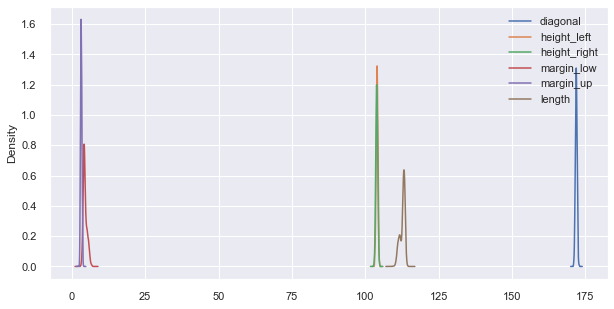

In [35]:
#  Avant normalisation
X1 = pd.DataFrame(df,columns=df.columns)
X1.plot(kind='density',sharex=True,figsize=(10,5),layout=(10,1))
plt.show()

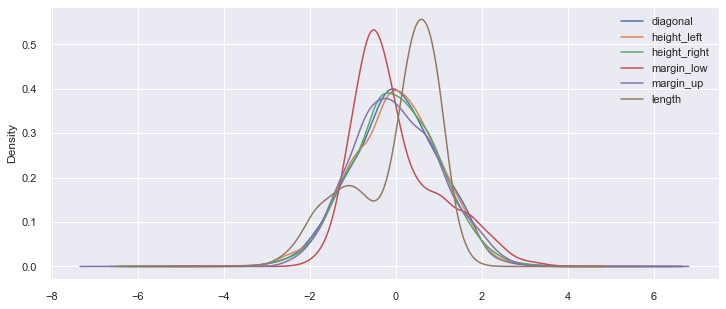

In [36]:
# Après normalisation
pd.DataFrame(X_scaled,columns=df.columns).plot(kind='density',sharex=True,
                                               figsize=(12,5),layout=(10,1))
plt.show()

In [37]:
pd.DataFrame(X_scaled, index=df.index,columns=df.columns).head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750


### Ratio de variance expliquée et Scree plot

In [38]:
# Création du modèle ACP
model_pca = PCA()

# Ajuster le modèle avec les données
X_reduced = model_pca.fit_transform(X_scaled)

In [39]:
# Ratio de variance expliquée
model_pca.explained_variance_ratio_.round(2)

array([0.43, 0.17, 0.13, 0.12, 0.1 , 0.05])

In [40]:
# Ratio de variance expliquée cumulé
model_pca.explained_variance_ratio_.cumsum().round(2)

array([0.43, 0.6 , 0.73, 0.85, 0.95, 1.  ])

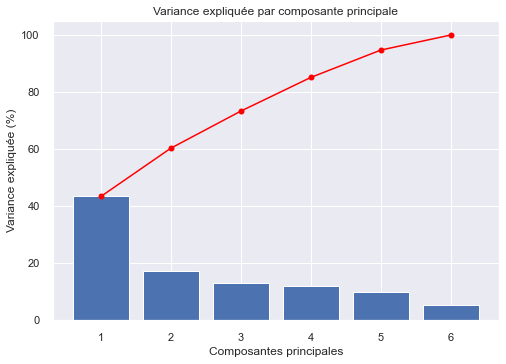

In [41]:
# Scree plot
display_scree_plot(model_pca)

**Observations :** 
- Les trois premiers composants couvre 77% des variables

In [42]:
# Nombre de composants à étudier
num_components = 2
pcs = model_pca.components_ 
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]

In [43]:
df.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [44]:
pc1

array([-0.08469767,  0.33063448,  0.39355544,  0.50769282,  0.4394146 ,
       -0.52705225])

In [45]:
pc2

array([ 0.94130387,  0.30752844,  0.10833184, -0.07243963, -0.00495445,
        0.04863598])

### Cercles de corrélation et projections de points

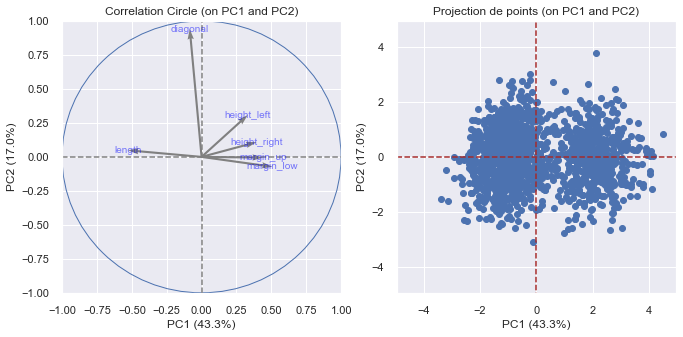

In [46]:
X_projected = model_pca.transform(X_scaled)

plt.figure(figsize=(11,11))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(0,1)], 
                labels = np.array(df.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(0,1)])
plt.show()

In [47]:
X_projected

array([[ 1.64413533,  0.74784336,  2.40251671,  3.18085156,  0.30398483,
        -0.01224666],
       [-2.01990995, -2.20749245, -1.00186403,  0.07293664,  0.03333482,
        -0.47550345],
       [-0.969864  ,  2.62049228,  1.19536388, -0.92362716, -0.83774922,
         0.2073435 ],
       ...,
       [ 1.88968443, -0.60028209, -0.54592206, -0.09804235, -0.29697655,
         0.50356217],
       [ 1.78978258,  0.51122987,  0.02810393, -0.47401805,  0.35665494,
         0.52471865],
       [ 1.04215891, -1.47130226,  0.48443988, -0.68518566,  0.48451961,
        -0.23511175]])

## Methode T-SNE

### Visualisation des données avec la méthode t-sne

*La méthode t-SNE (t-distributed stochastic neighbor embedding) fait partie de la librairie scikit-learn.*

**Projection en 2D**

In [48]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

In [49]:
X=initial_data.select_dtypes('number')
columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)]
X_tsne = pd.DataFrame(X_tsne, index=X.index, columns=columns)
X_tsne.head()

,DIM1,DIM2
0,3.139604,6.215448
1,-45.401073,-23.176100
2,2.519248,30.283636
3,-18.056858,-26.962479
4,6.367445,-9.231504


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='DIM1', ylabel='DIM2'>

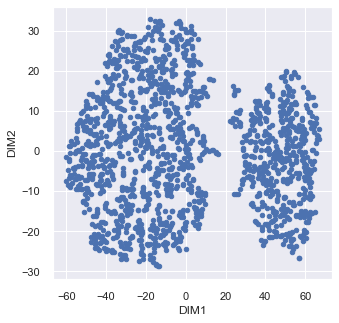

In [50]:
X_tsne.plot(x='DIM1', y='DIM2', kind='scatter', figsize=(5, 5))

In [51]:
# La divergence de Kullback-Leibler après optimisation
tsne.kl_divergence_

1.3768469095230103

# Analyse univariée sur la cible
---

In [52]:
target = initial_data[['is_genuine']]

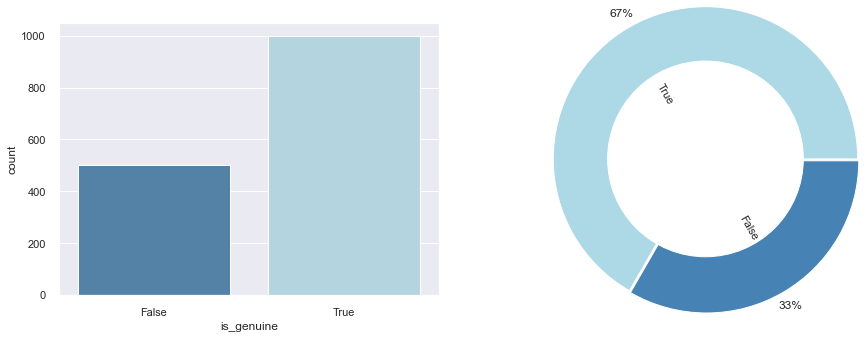

In [53]:
palette =["steelblue","lightblue",]
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x="is_genuine", data=initial_data, palette = palette)
plt.subplot(122)
initial_data["is_genuine"].value_counts().plot(kind="pie", ylabel='', 
                                       autopct='%1.0f%%', radius=1.4, 
                                       explode = (0, 0.02), 
                                       colors=["lightblue","steelblue"], 
                                       pctdistance=1.1, labeldistance=0.4, 
                                       rotatelabels=True)
circle = plt.Circle( (0,0), 0.9, color='white')
p = plt.gcf()
p.gca().add_artist(circle)

plt.show()

In [54]:
data_arch = initial_data.groupby(by="is_genuine").mean().round(2)
data_arch

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90,104.19,104.14,5.21,3.35,111.63
True,171.99,103.95,103.81,4.12,3.05,113.20


**Modèle-type d'un faux billet de banque :**

- diagonal → 171.90 mm

- height_left → 104.19 mm

- height_right → 104.14 mm

- margin_low → 5.21 mm

- margin_up → 3.35 mm

- length → 111.63 mm

**Modèle-type d'un vrai billet de banque :**

- diagonal → 171.99 mm

- height_left → 103.95 mm

- height_right → 103.81 mm

- margin_low → 4.12 mm

- margin_up → 3.05 mm

- length → 113.20 mm

 **Observation :**
 
 En général, les vrais billets ont une longueur et une diagonale plus élevées, tandis que les variables height_left, height_right, margin_low et margin_up sont plus élevées pour les faux billets.

# K-means clustering
---

## Trouver le nombre optimal de clusters pour la classification (méthode du coude)

**Observation :**
Selon la courbe du coude, le nombre optimal de clusters est de 3, mais pour la mission nous privilégierons la sélection de 2 clusters (billets "vrais" et "faux").

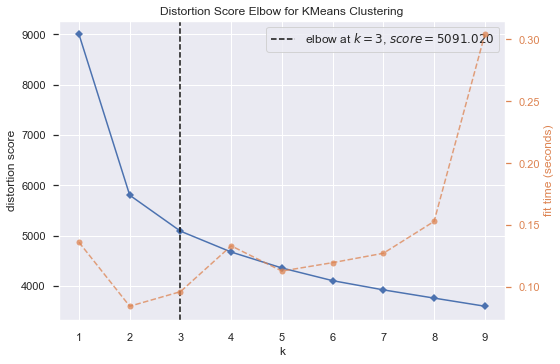

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k=(1,10),metric="distortion") 
visualizer.fit(X_scaled)
visualizer.show()

**Avis :**
Selon la courbe du coude, le nombre optimal de clusters est de 3, mais pour la mission nous privilégierons la sélection de 2 clusters (billets "vrais" et "faux").

##### Silhouette score

- La valeur du score de la silhouette se situe entre -1 et 1.

- Un score proche de 1 indique que le point de données est très similaire aux autres points de données de la grappe,

- Un score proche de -1 indique que le point de données n'est pas similaire aux points de données de son cluster.

In [56]:
range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.342747406913248)
For n_clusters = 3, silhouette score is 0.2104229970267939)
For n_clusters = 4, silhouette score is 0.19642537857056414)
For n_clusters = 5, silhouette score is 0.15664535385223544)
For n_clusters = 6, silhouette score is 0.1483885494837556)
For n_clusters = 7, silhouette score is 0.1436859615539382)
For n_clusters = 8, silhouette score is 0.14518291512224027)
For n_clusters = 9, silhouette score is 0.14195915850876037)


## K-means

In [57]:
# K-Means model avec 2 clusters
model_kmeans = KMeans(n_clusters=2)
model_kmeans.fit(X_scaled)

# Déterminer à quels clusters appartient chaque point de données
clusters =  model_kmeans.fit_predict(X_scaled)

# Ajout le numéro de cluster aux données originales mises à l'échelle.
X_clustered = pd.DataFrame(X_scaled, index=df.index,
                           columns=df.columns)
X_clustered["cluster"] = clusters

X_clustered.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651,1
1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666,0
2,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901,0
3,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075,0
4,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750,0


## Plan factoriel

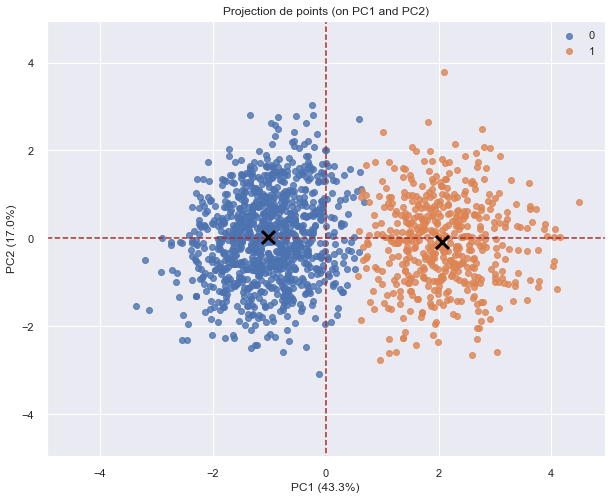

In [58]:
centres_reduced = model_pca.transform(model_kmeans.cluster_centers_)
plt.figure(figsize=(10,8))
display_factorial_planes(X_reduced, 2, model_pca, [(0,1)], 
                         illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
plt.show()

## Analyse des centroïdes

In [59]:
kmeans_ =  X_clustered.groupby(by="cluster").mean()
display(kmeans_)

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster,,,,,,
0,0.096000,-0.281946,-0.352419,-0.552445,-0.426924,0.593240
1,-0.194323,0.570713,0.713365,1.118257,0.864176,-1.200833


**Cluster 0 : vrais billets**

**Cluster 1 : faux billets**

Deux dimensions géométriques sont plus élévées sur le cluster 0 qui est le groupe des vrais billets. Il s'agit de :

- length qui est la longueur du billet (en mm)
- et diagonal qui représente la diagonale du billet (en mm)

Les 4 autres mésures sont quant à elles plus élévées sur le cluster1 qui est celui des faux billets. Ce sont :

- height_left : la hauteur du billet (mesurée sur le côté gauche, enmm)
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
- margin_up : la marge entre le bord supérieur du billet et l'image decelui-ci (en mm)
- margin_low : la marge entre le bord inférieur du billet et l'image decelui-ci (en mm)

## Modèle d'évaluation

In [60]:
# Ajouter le numéro de cluster à l'ensemble de données original
data_kmeans = initial_data.copy()
data_kmeans = pd.DataFrame(initial_data, index=data_kmeans.index, 
                           columns=data_kmeans.columns)
data_kmeans["cluster_kmeans"] = clusters

In [61]:
# Remplacer les valeurs de "is_genuine" par 1 et 0 et le renommer
data_kmeans['is_genuine'].replace([True, False],[1,0], inplace=True)
data_kmeans.rename(columns={"is_genuine":"cluster_origin"}, inplace=True)

In [62]:
data_kmeans.head()

,cluster_origin,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_kmeans
0,1,171.81,104.86,104.95,4.52,2.89,112.83,1
1,1,171.46,103.36,103.66,3.77,2.99,113.09,0
2,1,172.69,104.48,103.50,4.40,2.94,113.16,0
3,1,171.36,103.91,103.94,3.62,3.01,113.51,0
4,1,171.73,104.28,103.46,4.04,3.48,112.54,0


## Matrice de confusion

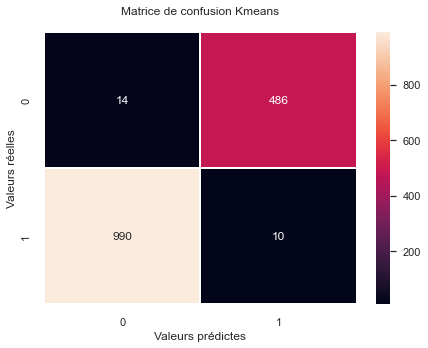

In [63]:
conf_matrix = pd.crosstab(data_kmeans['cluster_origin'], 
                          model_kmeans.labels_)
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("Valeurs prédictes")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion Kmeans\n")
plt.show()

**Observation :**

- Sur les 1000 vrais billets de la classe 0: nous avons 990 bien classés contre 10 mal classés → Nous avons 10 faux positifs soit 99% de taux de précision.

- Sur les 500 faux billets la classe 1: nous avons 486 bien classés contre 14 mal classés→ Nous avons 14 faux négatifs soit environ 98% de taux de précision.

# Régression logistique
---

*La régresssion logistique utilise une fonction analytique, appelée fonction logistique ou fonction sigmoïde, qui a une forme caractéristique en S. En optimisant les coefficients de cette courbe (max de vraisemblance ou min de cross-entropie), elle permet d'estimer la probabilité pour un échantillon d'appartenir à telle ou telle classe. Par exemple, tumoral versus normal.*

## Mise en œuvre

In [64]:
data_reglog = initial_data.copy()

# Définir les valeurs caractéristiques X et la valeur cible Y
x = data_reglog.iloc[:, 1:]
y = data_reglog.iloc[:, 0]

# Division des données (0,75/0,25 par défaut)
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y, random_state = 0, shuffle=True) 

# Instanciation du modèle
model_regLog = linear_model.LogisticRegression(random_state = 0, 
                solver = 'liblinear', multi_class = 'auto')

# Entrainement
model_regLog.fit(x_train,y_train)

# Taux de précision du modèle
precision_train = model_regLog.score(x_train,y_train)
precision_test = model_regLog.score(x_test,y_test)
print("Taux de précision du modèle d'entraînement :",round(precision_train*100,2),"%")
print("Taux de précision du modèle de validation :",round(precision_test*100,2),"%")

Taux de précision du modèle d'entraînement : 98.76 %
Taux de précision du modèle de validation : 99.73 %


## Tests prédictifs

In [65]:
# Test1
prediction_test1 = model_regLog.predict([[171.81,104.86,104.95,4.52,2.89,112.83]])
print(prediction_test1[0])

False


In [66]:
# Test 2
prediction_test2 = model_regLog.predict([[171.46,103.36,103.66,3.77,2.99,113.09]])
print(prediction_test2[0]);

True


In [67]:
# Predictions
y_pred_test = model_regLog.predict(x_test)

## Modèle d'évaluation

## Matrice de confusion

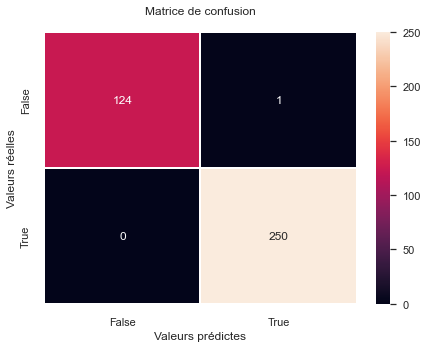

In [68]:
plt.figure(figsize=(7,5))
conf_matrix_reglog = pd.crosstab(y_test, y_pred_test)
sns.heatmap(conf_matrix_reglog, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("Valeurs prédictes")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion\n")
plt.show()

**Avis :**
- Sur les 124 faux billets → Nous avons 1 faux négatif → 99,6% de taux de précision.
- Sur les 250 vrais billets → Nous avons 0 faux positifs → Taux de précision de 100%.

## Mesure de la qualité de la classification (courbe ROC)

*Une courbe ROC (Receiver Operator Characteristic) est un graphique utilisé pour montrer la capacité de diagnostic des classificateurs binaires. L'aire sous la courbe représente la capacité du modèle à discriminer correctement les exemples négatifs et positifs, entre une classe ou une autre.*

*Une valeur de 1,0, soit la totalité de l'aire sous la courbe, représente un classificateur parfait. Cela signifie qu'une AUC de 0,5 est aussi bonne que de deviner au hasard. La courbe ROC est calculée en fonction de la sensibilité (taux de vrais positifs/rappel) et de la spécificité (taux de vrais négatifs).*

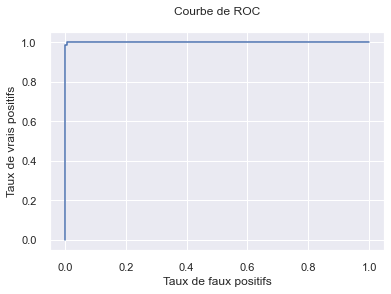

In [69]:
# Définir les métriques
plt.figure(figsize=(6,4))
y_pred_proba = model_regLog.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# Créer la courbe ROC
plt.plot(fpr,tpr)
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.title("Courbe de ROC\n")
plt.show()

**Avis :**
L'aire sous la courbe ROC (AUC) est presque égale à 1 → la classification est de très bonne qualité.

## Optimisation


In [70]:
grid = {"C":[1, 10, 100, 1000], 
         "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
         "penalty":["l1","l2","elasticnet","none"],
         "random_state":[0]}
model_opti = GridSearchCV(model_regLog, grid, cv = 10)
model_opti.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'random_state': [0],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [71]:
print("Hyperparamètres réglés (meilleurs paramètres) :",model_opti.best_params_)
print("Taux de précision du modèle :",round(model_opti.best_score_*100,2),"%")

Hyperparamètres réglés (meilleurs paramètres) : {'C': 1, 'penalty': 'none', 'random_state': 0, 'solver': 'newton-cg'}
Taux de précision du modèle : 99.02 %


**Evaluation du modèle**

In [72]:
# Prédictions
# Instanciation du modèle
model_opti = linear_model.LogisticRegression(C=1, penalty='l2', random_state=0, solver='newton-cg')
#model_regLog = linear_model.LogisticRegression(random_state = 0, 
                #solver = 'liblinear', multi_class = 'auto') => PRoblème d'incompatibilité du modèle en essayant d'optimisant le modèle, le problème se situe sur la 'penality'  => on conserve le modèle car il répond à la problématique métier

# Entrainement
model_opti.fit(x_train,y_train)

# Taux de précision du modèle
precision_train = model_opti.score(x_train,y_train)
precision_test = model_opti.score(x_test,y_test)
print("Taux de précision du modèle d'entraînement :",round(precision_train*100,2),"%")
print("Taux de précision du modèle de validation :",round(precision_test*100,2),"%")

y_pred_test = model_opti.predict(x_test)

Taux de précision du modèle d'entraînement : 98.84 %
Taux de précision du modèle de validation : 99.73 %


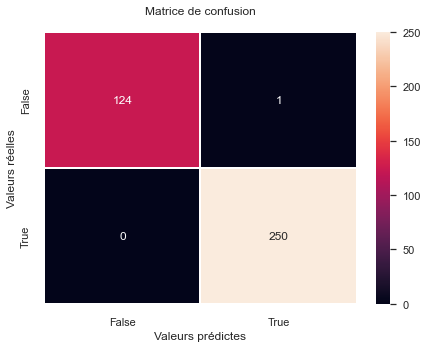

In [73]:
plt.figure(figsize=(7,5))
conf_matrix_reglog2 = pd.crosstab(y_test, y_pred_test)
sns.heatmap(conf_matrix_reglog2, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("Valeurs prédictes")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion\n")
plt.show()

**Avis :**

- Sur les 124 faux billets → Nous avons 1 faux négatif → 99,6% de taux de précision.
- Sur les 250 vrais billets → Nous avons 0 faux positifs → Taux de précision de 100%.

**Métriques de performance**

In [74]:
print("Taux de bonne classification est de ", round(accuracy_score(y_test, y_pred_test)*100, 2),"%")
print("Le score de précision est de ", round(precision_score(y_test, y_pred_test)*100, 2),"%")
print("Le score de rappel est de ", round(recall_score(y_test, y_pred_test)*100, 2),"%")
print("Le F1 score est de ", round(f1_score(y_test, y_pred_test)*100, 2),"%")

Taux de bonne classification est de  99.73 %
Le score de précision est de  99.6 %
Le score de rappel est de  100.0 %
Le F1 score est de  99.8 %


**Sélection finale :**
Au vu des résultats (taux de précision) de nos deux modèles, nous allons sélectionner le modèle de régression logistique pour la mise en œuvre de notre fonction de test.

# Validation croisée

## Pipeline

### Principe

In [75]:
random_state = 0
cross_validation = StratifiedKFold(n_splits=3, random_state=random_state, shuffle=True)

for train_index, test_index in cross_validation.split(X, y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    print('Train', X_train.shape, 'Test', X_test.shape)

Train (1000, 6) Test (500, 6)
Train (1000, 6) Test (500, 6)
Train (1000, 6) Test (500, 6)


### Calcul détaillé 

In [76]:
classifier = SVC(kernel='linear', random_state=random_state, class_weight='balanced')


pipeline = Pipeline([('scaler', scaler), ('classifier', classifier)])

accuracy = cross_val_score(pipeline, X, y, cv=cross_validation)
print("Scores de validation croisée: {}".format(accuracy))
print('Moyenne test accuracy', '{:.3f}'.format(accuracy.mean()))

Scores de validation croisée: [0.992 0.984 0.99 ]
Moyenne test accuracy 0.989


**Pourcentation des prédictions correctes**

- Itération 1 : 99,2%
- Itération 2 : 98,4%
- Itération 3 : 99%

Estimation de la performance svm est de 98,9% ce qui signifie que le modèle 98,9% de prédictions correctes en moyenne

# Mise en œuvre de la fonction de test
---

## Préparation des données

In [77]:
# Dataset à tester
billets_prod = pd.read_csv("billets_production.csv")
display(billets_prod.head())

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


## Application de la fonction de test

In [78]:
def fake_detect(file, model_opti):
    data = pd.read_csv(file)
    display(data.head())
    x = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]
    prediction = model_opti.predict(x)
    probability = model_opti.predict_proba(x)
    x["proba_false"] = probability[:,0]
    x["proba_true"] = probability[:,1]
    x["prediction"] = prediction
    x_fake_detect = pd.DataFrame(x, index=x.index, columns=x.columns)
    data_fake_detect = data.merge(x_fake_detect)
    
    print(" "*50,"*"*50,"\n")
    print('\033[1m' + "Nombre total de billets : " +  '\033[0m',len(x))
    print('\033[1m' + "Nombre total de faux billets : " +  '\033[0m',len(x[x["prediction"]== 0]))
    print('\033[1m' + "Nombre total de vrais billets : " +  '\033[0m',len(x[x["prediction"]== 1]), "\n")
    
    display(data_fake_detect)
    print(" "*50,"*"*50,"\n")

## Résultats des tests 

**Test 1**

---

In [79]:
fake_detect("billets_production.csv", model_opti)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


                                                   ************************************************** 

Nombre total de billets :  5
Nombre total de faux billets :  3
Nombre total de vrais billets :  2 



,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_false,proba_true,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.996543,0.003457,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.999039,0.000961,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.997948,0.002052,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.040082,0.959918,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.000686,0.999314,True


                                                   ************************************************** 



**Test 2 : soutenance projet**

---

In [80]:
# Dataset à tester
fake_detect("billets_test.csv", model_opti)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


                                                   ************************************************** 

Nombre total de billets :  5
Nombre total de faux billets :  3
Nombre total de vrais billets :  2 



,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_false,proba_true,prediction
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,0.011486,0.988514,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.993388,0.006612,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,0.001177,0.998823,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0.999838,0.000162,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.984397,0.015603,False


                                                   ************************************************** 

